In [1]:
#https://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
from gurobipy import *
from IPython.display import Audio
import os
import glob
import untangle

# Functions

In [2]:
# Function for transforming a signal with fourier
def fourier_trans(data, rate, begin_time, end_time): 
    # initialising variables
    tp_count = len(data)
    values = np.arange(int(tp_count/2))
    time_period = tp_count/rate
    frequencies = values/time_period
    
    #at what intervals time points are sampled
    sampling_interval = 1/rate;
    
    #time points
    time = np.arange(begin_time, end_time, sampling_interval);
    
    #Frequency domain representation
    fourier_transform = fft(data)/tp_count #normalized the amplitude
    fourier_transform = fourier_transform[range(int(len(data)/2))] #exclude sampling frequency   
    return frequencies, abs(fourier_transform)

# TODO: Funktion überarbeiten damit man es auch versteht!
def new_fft(data, rate):
    N = len(data)

    # sample spacing
    T = 1.0 / rate
    x = np.linspace(0.0, N*T, N)

    yf = fft(data)
    freq = np.linspace(0.0, 1.0/(2.0*T), N//2)
    ampl = 2.0/N * np.abs(yf[0:N//2])
    return freq, ampl

# Frequency domain representation
def plot_freq_domain(freq, fourier, name):
    plt.figure(figsize=(20,5))
    plt.plot(freq, fourier)
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1400)
    plt.title(name)
    plt.show()

# TODO: Warnung herausgeben wenn bei der Teilung der Samplerate eine Fliesskommazahl entsteht
def easy_downsampling(data, rate, sampl_fac):
    ds_data = []
    for i in range(len(data)):
        if (i%sampl_fac == 0):
            ds_data.append(data[i])
    ds_rate = int(rate/sampl_fac)
    return ds_data, ds_rate

def snip_wav(data, rate, start_sec, end_sec):
    start_point = int((rate * start_sec)-1)
    end_point = int((rate * end_sec)-1)
    #print('start_point:', start_point)
    #print('end_point:', end_point)
    snip_data = data[start_point:end_point]
    #print(snip_data)  
    return snip_data, rate

##  Set audio snippets and sample compression

In [3]:
start_sec = 1
end_sec = 1.1
sampl_fac = 4

# Dictonary

In [4]:
# Read WAV File

audio_files = []
path_wav = "audiofile"
path_xml = "annotation"

# Init dict
ref_note = {}
note = 0

for filename in glob.glob(os.path.join(path_xml, '*.xml')):
    
    # Read data from xml
    obj = untangle.parse(filename)
    audiofile = obj.instrumentRecording.globalParameter.audioFileName.cdata
    pitch = obj.instrumentRecording.transcription.event.pitch.cdata
    #onsetSec = obj.instrumentRecording.transcription.event.onsetSec.cdata
    #offsetSec = obj.instrumentRecording.transcription.event.offsetSec.cdata
    fretNumber = obj.instrumentRecording.transcription.event.fretNumber.cdata
    stringNumber = obj.instrumentRecording.transcription.event.stringNumber.cdata
    
    # Read wav
    wav_file = path_wav + '/' + audiofile
    rate, data = wav.read(wav_file)
    
    # Snip and downsampling audio-file
    data, rate = snip_wav(data, rate, start_sec, end_sec)
    data, rate = easy_downsampling(data, rate, sampl_fac)
    
    # Calc FFT
    #freq, fourier = fourier_trans(data, rate, float(onsetSec), float(offsetSec))
    #freq, fourier = fourier_trans(data, rate, 0, 2.5)
    #freq, fourier = fourier_trans(data, rate, 0, end_sec-start_sec)
    freq, fourier = new_fft(data, rate)
    
    # Update Dict
    #ref_note[filename] = {
    ref_note[note] = {
        "pitch": int(pitch),
        "fret": int(fretNumber),
        "string": int(stringNumber),
        "rate": int(rate),
        "data": data,
        #"onset": float(onsetSec), 
        #"offset": float(offsetSec), 
        "freq": freq,
        "fourier": fourier,
    }
    note+=1

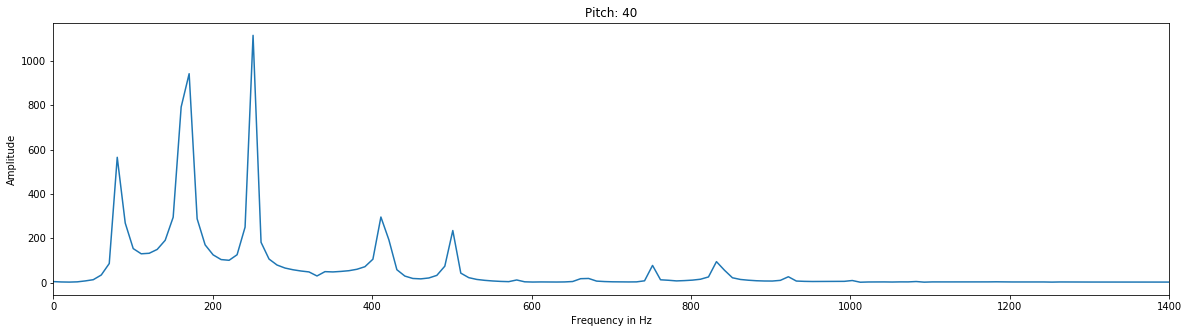

data: 1103
rate: 11025


In [5]:
tone = 0
plot_freq_domain(ref_note[tone]['freq'], ref_note[tone]['fourier'],'Pitch: %g' %ref_note[tone]['pitch'])
print('data:', len(ref_note[tone]['data']))
print('rate:', ref_note[tone]['rate'])

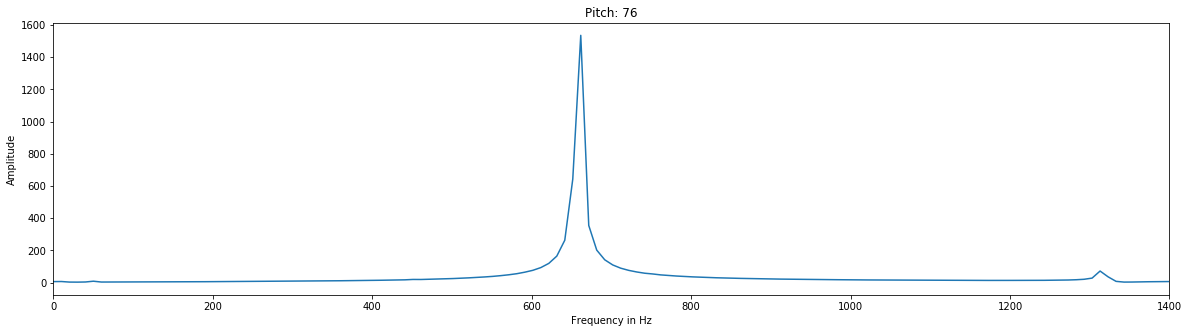

data: 1103
rate: 11025


In [6]:
tone = 77
plot_freq_domain(ref_note[tone]['freq'], ref_note[tone]['fourier'], 'Pitch: %g' %ref_note[tone]['pitch'])
print('data:', len(ref_note[tone]['data']))
print('rate:', ref_note[tone]['rate'])

# Read audiofile for approximation

In [7]:
# Chords
#rate_chord, data_chord = wav.read('audiofile/1-E1-Major 00.wav')
#rate_chord, data_chord = wav.read('audiofile/1-E1-Major 01.wav')

# Single note
#rate_chord, data_chord = wav.read('audiofile/G53-65601-1111-00067.wav')
rate_chord, data_chord = wav.read('audiofile/G53-40100-1111-00001.wav')

# Single note played on another guitar
#rate_chord, data_chord = wav.read('audiofile/G53-42102-1111-237.wav')

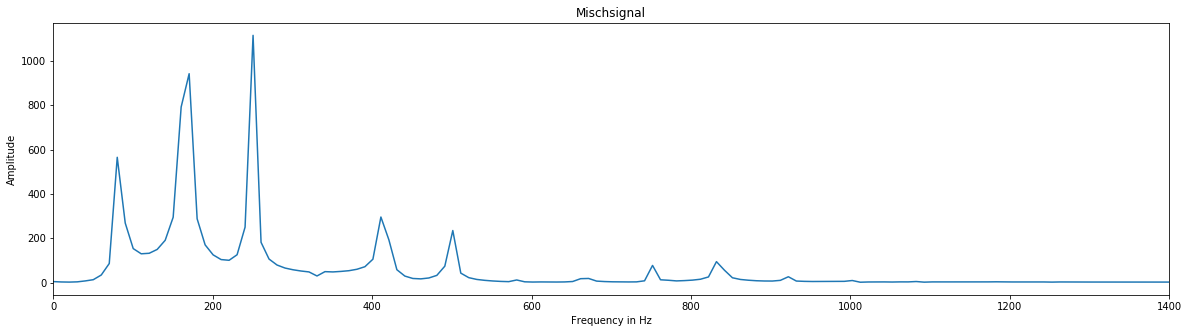

data: 1103
rate: 11025
Länge Mischsignal:  551


In [8]:
# mischsignal mischsignal
data_20, rate_20 = snip_wav(data_chord, rate_chord, start_sec, end_sec)
data_ds, rate_ds = easy_downsampling(data_20, rate_20, sampl_fac)
freq, mischsignal = new_fft(data_ds, rate_ds)

plot_freq_domain(freq, mischsignal, 'Mischsignal')
print('data:', len(data_ds))
print('rate:', rate_ds)
print('Länge Mischsignal: ', len(mischsignal))

# Gurobi

In [9]:
# Build Model
m = Model('AMt')
#m.setParam(GRB.Param.NodefileStart , 0.5)
#m.setParam(GRB.Param.Threads, 1.0)

lambs = []
#for lamb in range(len(ref_note)):
for lamb in range(11): # Nur die ersten 12 Töne verwendet
    lambs.append(m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
m.update()

Academic license - for non-commercial use only


In [10]:
%%time
#Optimize Signal

deviation = 0
approxi_sgn = 0
 
#for sgn in range(len(mischsignal)):
for sgn in range(100):
    for lamb in range(len(lambs)):
        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]
        
    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))
    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'
    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden
    # Überprüfen ob der Betrag der Differenz besser geeignet ist?
print('Deviation is calculated.')

Deviation is calculated.
Wall time: 19.9 s


In [ ]:
%%time
m.setObjective(deviation, GRB.MINIMIZE)
m.optimize()
 
for v in m.getVars():
    print('%s: %g' % (v.varName, v.x))